# Implement Kalman model using FastAI

> need to implement custom data preparation pipeline and loss function 

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.fastai

In [ ]:
from fastai.tabular.core import *
from fastai.data.core import *

In [ ]:
#| export
from meteo_imp.utils import *
from meteo_imp.gaussian import *
from meteo_imp.data import *

from fastcore.transform import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.all import *
from fastai.tabular import *
from fastai.data import *
from fastai.torch_core import default_device, to_device
from dataclasses import dataclass

import torch

import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
reset_seed()

In [ ]:
hai_path

Path('/home/simone/Documents/uni/Thesis/GPFA_imputation/data/FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4_float32.parquet')

In [ ]:
hai = pd.read_parquet(hai_path)
hai64 = pd.read_parquet(hai_path64)
hai_era = pd.read_parquet(hai_era_path)
hai_era64 = pd.read_parquet(hai_era_path64)

## Data Preparation

The aim of the data preparation pipeline is to:
- take the original time series and split it into time blocks
- for each block generate a random gap (need to figure out the properties of the gap)
- split some time blocks for testing

the input of the pipeline is:
- a dataframe containing all observations

the input of the model is:
- observed data (potentially containing NaN where data is missing)
- missing data mask (which is telling where the data is missing)
- the data needs to be standardized

### Utils

In [ ]:
#| export
from dominate.tags import *

In [ ]:
#| export
@patch
def _repr_html_(self: Transform, as_str=True):
    with div() as out:
        p(strong(self.name))
        p(repr(self.encodes))
        p(repr(self.decodes))
    out = str(out) if as_str else out
    return out

In [ ]:
#| export
@patch
def _repr_html_(self: TfmdLists):
    with div() as out:
        span("TfmdLists. Items:")
        pre(repr(self.items))
        ol([li(f._repr_html_(as_str=False)) for f in self.fs], start="0")
    return str(out)

### 1) Block Index

the first step is to transfrom the original dataframe into blocks of a specified `block_len`

two different strategies are possible:

- contigous blocks
- random block in the dataframe

for now contigous blocks are used

In [ ]:
#| export
class BlockIndexTransform(Transform):
    """divide timeseries DataFrame index into blocks"""
    def __init__(self, idx: pd.DatetimeIndex, block_len:int =200, offset=1):
        store_attr()
        self.n = len(idx)
        
    def encodes(self, i:int) -> pd.DatetimeIndex:       
        start = i * self.block_len + self.offset
        end = (i+1) * self.block_len + self.offset
        assert end <= self.n 
        
        return self.idx[start:end] 

In [ ]:
blk = BlockIndexTransform(hai.index, 10)

In [ ]:
blk

BlockIndexTransform:
encodes: (int,object) -> encodes
decodes:

In [ ]:
hai.index

DatetimeIndex(['2000-01-01 00:30:00', '2000-01-01 01:00:00',
               '2000-01-01 01:30:00', '2000-01-01 02:00:00',
               '2000-01-01 02:30:00', '2000-01-01 03:00:00',
               '2000-01-01 03:30:00', '2000-01-01 04:00:00',
               '2000-01-01 04:30:00', '2000-01-01 05:00:00',
               ...
               '2012-12-31 19:30:00', '2012-12-31 20:00:00',
               '2012-12-31 20:30:00', '2012-12-31 21:00:00',
               '2012-12-31 21:30:00', '2012-12-31 22:00:00',
               '2012-12-31 22:30:00', '2012-12-31 23:00:00',
               '2012-12-31 23:30:00', '2013-01-01 00:00:00'],
              dtype='datetime64[ns]', name='time', length=227952, freq=None)

In [ ]:
blk(2)

DatetimeIndex(['2000-01-01 11:00:00', '2000-01-01 11:30:00',
               '2000-01-01 12:00:00', '2000-01-01 12:30:00',
               '2000-01-01 13:00:00', '2000-01-01 13:30:00',
               '2000-01-01 14:00:00', '2000-01-01 14:30:00',
               '2000-01-01 15:00:00', '2000-01-01 15:30:00'],
              dtype='datetime64[ns]', name='time', freq=None)

### 2) Meteo Imp Block DataFrames

Get a chunck out of dataframes given an index

In [ ]:
#| export
@dataclass
class DataControl:
    data: pd.DataFrame
    control: pd.DataFrame
    def _repr_html_(self):
            return row_dfs({'data': self.data, 'control': self.control}, title="Data Control", hide_idx=False)
    def __iter__(self): return iter((self.data, self.control,))

In [ ]:
df = hai.loc[blk(1)]

In [ ]:
#| export
def _rename_lag(lag):
    def _inner(col_name):
        return f"{col_name}_lag_{lag}"
    return _inner

In [ ]:
df.rename(columns=_rename_lag(1))

,TA_lag_1,SW_IN_lag_1,VPD_lag_1
time,,,
2000-01-01 06:00:00,-0.23,0.00,0.122
2000-01-01 06:30:00,-0.22,0.00,0.098
2000-01-01 07:00:00,-0.24,0.00,0.066
2000-01-01 07:30:00,-0.23,0.00,0.044
2000-01-01 08:00:00,-0.22,0.00,0.026
2000-01-01 08:30:00,-0.19,0.45,0.016
2000-01-01 09:00:00,-0.14,3.70,0.010
2000-01-01 09:30:00,-0.03,7.26,0.006
2000-01-01 10:00:00,0.04,12.24,0.006


In [ ]:
#| export
def _lag_df(df, lag):
    "add lagged columns"
    df_lag = df.shift(lag).rename(columns = _rename_lag(lag))
    return df_lag
    

In [ ]:
_lag_df(df, 1)

,TA_lag_1,SW_IN_lag_1,VPD_lag_1
time,,,
2000-01-01 06:00:00,NaN,NaN,NaN
2000-01-01 06:30:00,-0.23,0.00,0.122
2000-01-01 07:00:00,-0.22,0.00,0.098
2000-01-01 07:30:00,-0.24,0.00,0.066
2000-01-01 08:00:00,-0.23,0.00,0.044
2000-01-01 08:30:00,-0.22,0.00,0.026
2000-01-01 09:00:00,-0.19,0.45,0.016
2000-01-01 09:30:00,-0.14,3.70,0.010
2000-01-01 10:00:00,-0.03,7.26,0.006


In [ ]:
#| export
def _add_lags_df(df, lags):
    df_lagged = df
    for lag in listify(lags):
        df_lagged = pd.merge(df_lagged, _lag_df(df, lag), left_index=True, right_index=True)
    return df_lagged

In [ ]:
_add_lags_df(df, [1,2])

,TA,SW_IN,VPD,TA_lag_1,SW_IN_lag_1,VPD_lag_1,TA_lag_2,SW_IN_lag_2,VPD_lag_2
time,,,,,,,,,
2000-01-01 06:00:00,-0.23,0.00,0.122,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 06:30:00,-0.22,0.00,0.098,-0.23,0.00,0.122,NaN,NaN,NaN
2000-01-01 07:00:00,-0.24,0.00,0.066,-0.22,0.00,0.098,-0.23,0.00,0.122
2000-01-01 07:30:00,-0.23,0.00,0.044,-0.24,0.00,0.066,-0.22,0.00,0.098
2000-01-01 08:00:00,-0.22,0.00,0.026,-0.23,0.00,0.044,-0.24,0.00,0.066
2000-01-01 08:30:00,-0.19,0.45,0.016,-0.22,0.00,0.026,-0.23,0.00,0.044
2000-01-01 09:00:00,-0.14,3.70,0.010,-0.19,0.45,0.016,-0.22,0.00,0.026
2000-01-01 09:30:00,-0.03,7.26,0.006,-0.14,3.70,0.010,-0.19,0.45,0.016
2000-01-01 10:00:00,0.04,12.24,0.006,-0.03,7.26,0.006,-0.14,3.70,0.010


In [ ]:
#| export
class BlockDfTransform(Transform):
    """divide timeseries DataFrame index into blocks"""
    def __init__(self, data: pd.DataFrame, control: pd.DataFrame, control_lags: int|Iterable[int]):
        store_attr()
        self.control = _add_lags_df(control, control_lags)
    def encodes(self, idx: pd.DatetimeIndex) -> DataControl:
        return DataControl(self.data.loc[idx], self.control.loc[idx])

In [ ]:
blkdf = BlockDfTransform(hai, hai_era, 1)

In [ ]:
blkdf(blk(1))

,TA,SW_IN,VPD
time,,,
2000-01-01 06:00:00,-0.2300,0.0000,0.1220
2000-01-01 06:30:00,-0.2200,0.0000,0.0980
2000-01-01 07:00:00,-0.2400,0.0000,0.0660
2000-01-01 07:30:00,-0.2300,0.0000,0.0440
2000-01-01 08:00:00,-0.2200,0.0000,0.0260
2000-01-01 08:30:00,-0.1900,0.4500,0.0160
2000-01-01 09:00:00,-0.1400,3.7000,0.0100
2000-01-01 09:30:00,-0.0300,7.2600,0.0060
2000-01-01 10:00:00,0.0400,12.2400,0.0060


taking a day in the summer so there is an higher values for the variables

In [ ]:
blkdf(blk(800)).data

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.22,224.800003,5.799
2000-06-15 17:30:00,14.11,195.279999,6.577
2000-06-15 18:00:00,14.23,244.169998,6.931
2000-06-15 18:30:00,14.40,253.919998,7.286
2000-06-15 19:00:00,14.09,177.309998,7.251
2000-06-15 19:30:00,13.71,97.070000,6.683
2000-06-15 20:00:00,13.08,39.709999,5.851
2000-06-15 20:30:00,12.41,10.650000,5.254
2000-06-15 21:00:00,12.27,0.320000,5.164


In [ ]:
tfms1 = TfmdLists([800,801,802,803], [BlockIndexTransform(hai.index, 10), BlockDfTransform(hai, hai_era, control_lags=1)])

In [ ]:
tfms1[0]

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


### 3) Gaps

adds a mask which includes a random gap

#### Make random Gap

In [ ]:
idx = L(*tfms1[0].data.columns).argwhere(lambda x: x in ['TA','SW_IN'])

In [ ]:
mask = np.ones_like(tfms1[0].data, dtype=bool)

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: Optional[int] = None # Optional start of gap
)-> np.ndarray: # [total_length] array of bools to indicicate if the data is missing or not
    "Add a continous gap of given length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    gap_start = np.random.randint(total_length - gap_length) if gap_start is None else gap_start
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
gap = _make_random_gap(2, 10, 2)

In [ ]:
gap

array([False, False,  True,  True, False, False, False, False, False,
       False])

In [ ]:
np.argwhere(gap)

array([[2],
       [3]])

In [ ]:
mask[np.argwhere(gap), idx] = False

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True],
       [False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
mask[gap]

array([[False, False,  True],
       [False, False,  True]])

#### Gap Len Generator

The gap lengths are drawn from a gamma distribution, so we have a long tail and a min value of 0, but compared to an exponentail distributions we don't have many gaps of len 0


$$ p(x)=\frac{1}{\Gamma(k) \theta^k} x^{k - 1} e^{-\frac{x}{\theta}}$$

$$\begin{align}\mu &= k\theta\\
m &= (k-1)\theta \end{align}$$
where $m$ is the mode and $\mu$ is the mean (for $k>1$), which is what we want

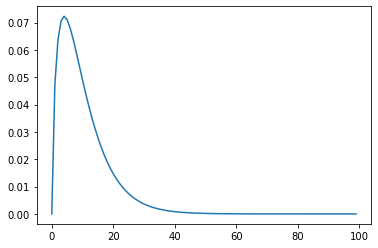

In [ ]:
import matplotlib.pyplot as plt

import scipy.special as sps  

mean = 10

scale = mean * .6
shape = mean/scale

mode = (shape-1)*scale

x = np.arange(0,100)

y = x**(shape-1)*(np.exp(-x/scale) / (sps.gamma(shape)*scale**shape))

plt.plot(x, y)  

plt.show()

This is a very guessestimate of a good probability density distribution of the gap len. The actual measure should come from the fluxnet data

In [ ]:
#| export
def gen_gap_len(mean: float): 
    scale = mean*.6
    shape = mean/scale
    yield int(np.random.gamma(scale=scale, shape=shape))

In [ ]:
next(gen_gap_len(1))

2

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

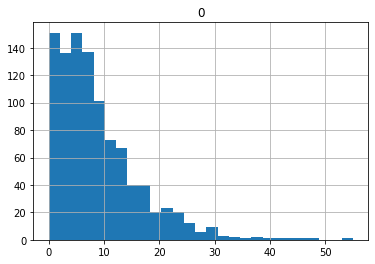

In [ ]:
gap_lens_sample = pd.DataFrame([next(gen_gap_len(10)) for _ in range(1000)])
gap_lens_sample.hist(bins=gap_lens_sample[0].max()//2)

#### Var Sel Generator 

draws a number of variables from a uniform distribution from 1 to the max n of vars and then select the variables with equal probability

In [ ]:
#| export
def gen_var_sel(vars):
    n_var = np.random.randint(1,len(vars))
    yield np.random.choice(np.array(vars), size=n_var, replace=False)

In [ ]:
next(gen_var_sel(list("abcdefg")))

array(['e', 'a'], dtype='<U1')

#### Add Gap Transform

In [ ]:
from collections.abc import Iterable, Generator

In [ ]:
#| export
def as_generator(x: Generator|object):
    """Maybe convert iterable to generator"""
    if isinstance(x, Generator): return x
    else: return cycle((x,))

In [ ]:
g = gen_var_sel(list("abcdefg")) 

In [ ]:
isinstance(g, Iterable)

True

In [ ]:
as_generator(gen_var_sel(list("abcdefg"))), next(as_generator(gen_var_sel(list("abcdefg"))))

(<generator object gen_var_sel>,
 array(['b', 'g', 'f', 'd'], dtype='<U1'))

In [ ]:
as_generator([1,2]), next(as_generator([1,2]))

(<itertools.cycle>, [1, 2])

In [ ]:
#| export
class MeteoImpDf:
    def __init__(self,*args):
        self.data = args[0]
        self.mask = args[1]
        self.control = args[2]
    def __iter__(self): return iter((self.data, self.mask, self.control,))
    __repr__ = basic_repr("data, mask, control")
    def _repr_html_(self):
        return row_dfs({'data': self.data, 'mask': self.mask, 'control': self.control}, title="Meteo Imp Df", hide_idx=False)

In [ ]:
#| export
class AddGapTransform(Transform):
    """Adds a random gap to a dataframe"""
    def __init__(self,
                variables,
                gap_length,
                ):
        self.variables, self.gap_length = as_generator(variables), as_generator(gap_length)
    def encodes(self, dc: DataControl) -> MeteoImpDf:
        df, control = dc
        gap = _make_random_gap(next(self.gap_length), df.shape[0])
        mask = np.ones_like(df, dtype=bool)
        col_sel = L(*df.columns).argwhere(lambda x: x in next(self.variables))
        mask[np.argwhere(gap), col_sel] = False
        mask = pd.DataFrame(mask, index=df.index, columns=df.columns)
        return MeteoImpDf(df, mask, control)

In [ ]:
a_gap = AddGapTransform(['TA', 'VPD'], 5)
a_gap

AddGapTransform:
encodes: (DataControl,object) -> encodes
decodes:

In [ ]:
[next(a_gap.variables) for _ in range(5)], [next(a_gap.gap_length) for _ in range(5)]

([['TA', 'VPD'], ['TA', 'VPD'], ['TA', 'VPD'], ['TA', 'VPD'], ['TA', 'VPD']],
 [5, 5, 5, 5, 5])

In [ ]:
a_gap(tfms1[0])

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


In [ ]:
tfms2 = TfmdLists([800,801,802,803], [*tfms1.fs, AddGapTransform(['TA','SW_IN'], 2)])

In [ ]:
tfms2[0]

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


In [ ]:
m_df = tfms2[0]

In [ ]:
#| export
@patch
def tidy(self: MeteoImpDf):
    data = self.data.reset_index().melt("time")
    mask = self.mask.reset_index().melt("time", value_name="is_present")
    
    return pd.merge(data, mask, on=["time", "variable"])

In [ ]:
m_df.tidy()

,time,variable,value,is_present
0,2000-06-15 17:00:00,TA,14.220000,True
1,2000-06-15 17:30:00,TA,14.110000,False
2,2000-06-15 18:00:00,TA,14.230000,False
3,2000-06-15 18:30:00,TA,14.400000,True
4,2000-06-15 19:00:00,TA,14.090000,True
5,2000-06-15 19:30:00,TA,13.710000,True
6,2000-06-15 20:00:00,TA,13.080000,True
7,2000-06-15 20:30:00,TA,12.410000,True
8,2000-06-15 21:00:00,TA,12.270000,True
9,2000-06-15 21:30:00,TA,12.200000,True


#### Plotting

In [ ]:
#| export
import altair as alt
from altair import datum

In [ ]:
#| exporti
def def_selection():
    return alt.selection_interval(bind="scales")

##### Rug

In [ ]:
#| exporti
def plot_rug(df, sel = def_selection(), props = {}):
    if 'height' in props:
        props = props.copy() 
        props.pop('height') # rug should have default heigth
    return alt.Chart(df).mark_tick(
            color='black',
        ).encode(
            x = "time",
            color = alt.condition(datum.is_present, alt.value('white'), alt.value('black'))
        ).add_params(
            sel
        ).properties(**props) 

In [ ]:
plot_rug(m_df.tidy())

alt.Chart(...)

In [ ]:
df = m_df.tidy()

In [ ]:
df = df[df.variable=="TA"].copy()

In [ ]:
df['row_number'] = df.reset_index().index

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 17:00:00,TA,14.22,True,0
1,2000-06-15 17:30:00,TA,14.11,False,1
2,2000-06-15 18:00:00,TA,14.23,False,2
3,2000-06-15 18:30:00,TA,14.40,True,3
4,2000-06-15 19:00:00,TA,14.09,True,4
5,2000-06-15 19:30:00,TA,13.71,True,5
6,2000-06-15 20:00:00,TA,13.08,True,6
7,2000-06-15 20:30:00,TA,12.41,True,7
8,2000-06-15 21:00:00,TA,12.27,True,8
9,2000-06-15 21:30:00,TA,12.20,True,9


In [ ]:
df.iloc[1]

time          2000-06-15 17:30:00
variable                       TA
value                       14.11
is_present                  False
row_number                      1
Name: 1, dtype: object

In [ ]:
df.loc[2, "is_present"] = True

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 17:00:00,TA,14.22,True,0
1,2000-06-15 17:30:00,TA,14.11,False,1
2,2000-06-15 18:00:00,TA,14.23,True,2
3,2000-06-15 18:30:00,TA,14.40,True,3
4,2000-06-15 19:00:00,TA,14.09,True,4
5,2000-06-15 19:30:00,TA,13.71,True,5
6,2000-06-15 20:00:00,TA,13.08,True,6
7,2000-06-15 20:30:00,TA,12.41,True,7
8,2000-06-15 21:00:00,TA,12.27,True,8
9,2000-06-15 21:30:00,TA,12.20,True,9


In [ ]:
i = 1
prev, curr, _next= df.iloc[i-1], df.iloc[i], df.iloc[i+1]

In [ ]:
prev, curr, _next

(time          2000-06-15 17:00:00
 variable                       TA
 value                       14.22
 is_present                   True
 row_number                      0
 Name: 0, dtype: object,
 time          2000-06-15 17:30:00
 variable                       TA
 value                       14.11
 is_present                  False
 row_number                      1
 Name: 1, dtype: object,
 time          2000-06-15 18:00:00
 variable                       TA
 value                       14.23
 is_present                   True
 row_number                      2
 Name: 2, dtype: object)

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 17:00:00,TA,14.22,True,0
1,2000-06-15 17:30:00,TA,14.11,False,1
2,2000-06-15 18:00:00,TA,14.23,True,2
3,2000-06-15 18:30:00,TA,14.40,True,3
4,2000-06-15 19:00:00,TA,14.09,True,4
5,2000-06-15 19:30:00,TA,13.71,True,5
6,2000-06-15 20:00:00,TA,13.08,True,6
7,2000-06-15 20:30:00,TA,12.41,True,7
8,2000-06-15 21:00:00,TA,12.27,True,8
9,2000-06-15 21:30:00,TA,12.20,True,9


In [ ]:
for i in range(len(df)):
    # handle boundaries
    prev = df.iloc[i-1].is_present if i>0 else True 
    _next = df.iloc[i+1].is_present if i<(len(df)-1) else True 
    curr = df.iloc[i]
    if not curr.is_present and prev:
        print("gap start", curr.time)
    if not curr.is_present and _next:
        print("gap end", curr.time)

gap start 2000-06-15 17:30:00
gap end 2000-06-15 17:30:00


In [ ]:
#| export
def find_gap_limits(df):
    gap_starts, gap_ends = [], []
    for i in range(len(df)):
        prev = df.iloc[i-1].is_present if i>0 else True 
        _next = df.iloc[i+1].is_present if i<(len(df)-1) else True 
        curr = df.iloc[i]
        if not curr.is_present and prev: gap_starts.append(curr.time)
        if not curr.is_present and _next: gap_ends.append(curr.time)
    return pd.DataFrame({'gap_start': gap_starts, 'gap_end': gap_ends})
    

In [ ]:
find_gap_limits(df)

,gap_start,gap_end
0,2000-06-15 17:30:00,2000-06-15 17:30:00


In [ ]:
#| export
def plot_missing_area(df, sel = def_selection(), props={}):
    gap_limits = find_gap_limits(df)
    start = alt.Chart(gap_limits).mark_rule().encode(
        x = alt.X('gap_start', axis=alt.Axis(domain=False, labels = False, ticks=False, title=None)),
    )
    end = alt.Chart(gap_limits).mark_rule().encode(
        x = alt.X('gap_end', axis=alt.Axis(domain=False, labels = False, ticks=False, title=None))
    )
    area = alt.Chart(gap_limits).mark_rect(color='black', opacity=.15).encode(
        x = alt.X('gap_start', axis=alt.Axis(domain=False, labels = False, ticks=False, title=None)),
        x2 = 'gap_end'
    )
    return (start + end + area)#.add_params(sel).properties(**props)

In [ ]:
plot_missing_area(df)

alt.LayerChart(...)

##### Points

In [ ]:
#| export
def plot_points(df, y = "value", y_label = "", sel = def_selection(), props = {}):
    return alt.Chart(df).mark_point(
            color='black',
            strokeWidth = 1,
            fillOpacity = 1
        ).encode(
            x = alt.X("time", axis=alt.Axis(domain=True, labels = True, ticks=True, title="time")),
            y = alt.Y(y, title = y_label, scale=alt.Scale(zero=False)),
            fill= alt.Fill("is_present", scale = alt.Scale(range=["black", "#ffffff00"]),
                           legend = alt.Legend(title =["Observed data"])),
            shape = "is_present",
        )

In [ ]:
plot_points(m_df.tidy())

alt.Chart(...)

##### Line

In [ ]:
#| exporti
def plot_line(df, only_present=True, y="value", y_label = "", sel = def_selection(), props = {}):
    # df = df[df.is_present] if only_present else df
    # TODO remove onle_present
    return alt.Chart(df).mark_line().encode(
        x = "time",    
        y = alt.Y(y, title = y_label, scale=alt.Scale(zero=False)),
        color='variable'
    ).add_params(
        sel
    ).properties(
        **props
    )#.transform_filter(
    #     datum.is_present
    # )

    

In [ ]:
plot_line(m_df.tidy())

alt.Chart(...)

##### Errorband

In [ ]:
#| exporti
def plot_error(df, y = "value", y_label = "", sel = def_selection(), props = {}):
    df.loc[:,'err_low'] = df[y] - 2 * df['std']
    df.loc[:,'err_high'] = df[y] + 2 * df['std']
    return alt.Chart(df).mark_errorband().encode(
        x = "time",    
        y = alt.Y("err_low:Q", title = y_label, scale=alt.Scale(zero=False)),
        y2 = "err_high:Q",
        color=alt.Color("variable",
                        legend = alt.Legend(title=["Line: pred. mean", "area: +/- 2 std"])
                       )
    ).add_params(
        sel
    ).properties(
        **props
    )
    

In [ ]:
plot_error(m_df.tidy().assign(std=5))

alt.Chart(...)

##### Variable

In [ ]:
#| exporti
def plot_variable(df, variable, ys=["value", "value"], title="", y_label="", sel = None, error=False, props = {}):
    df = df[df.variable == variable].copy()
    sel = ifnone(sel, def_selection())
    # rug = plot_rug(df, sel, props)
    points = plot_points(df, ys[0], y_label, sel, props)
    if not df.is_present.all(): points += plot_missing_area(df, sel, props) # there is a gap
    line = plot_line(df, True, ys[1], y_label, sel, props)
    if error: line = plot_error(df, y=ys[1], y_label=y_label, sel=sel, props=props) + line
    
    return (points + line).properties(title=title)
    
    # return alt.VConcatChart(vconcat=[(points + line), rug], spacing=-10).properties(title=title)

In [ ]:
plot_variable(m_df.tidy(), "TA", title="title TA")

alt.LayerChart(...)

In [ ]:
plot_variable(m_df.tidy().assign(std=.5), "TA", title="title TA", error=True)

alt.LayerChart(...)

##### Facet

In [ ]:
#| export
def facet_variable(df, # tidy dataframe
                   n_cols: int = 3,
                   bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
                   error:bool=False, # plot error bar
                   ys:list=["value", "value"],
                   props:dict|None = None, # additional properties for altair plot (eg. size)
                   ) -> alt.Chart:
    """Plot all values of the column `variable` in different subplots"""
    props = ifnone(props, {'width': 200, 'height': 150})
    vars = df.variable.unique()
    plot_list = [alt.hconcat() for _ in range(0, len(vars), n_cols)]
    selection_scale = alt.selection_interval(bind="scales", encodings=['x']) if bind_interaction else None
    for idx, variable in enumerate(vars):
        plot = plot_variable(df,
                            variable,
                            ys = ys,
                            title = variable,
                            y_label = variable,
                            sel = selection_scale,
                            props=props,
                            error=error)
        
        plot_list[idx // n_cols] |= plot
    
    plot = alt.vconcat(*plot_list)
    
    return plot

##### Show

In [ ]:
#| export
@patch
def show(self: MeteoImpDf, ax=None, ctx=None, 
        n_cols: int = 3,
        bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
        props:dict = None # additional properties (eg. size) for altair plot
       ) -> alt.Chart:
    
    df = self.tidy()
    return facet_variable(df, n_cols, bind_interaction, props)

In [ ]:
m_df.show(bind_interaction = False)

alt.VConcatChart(...)

In [ ]:
tfms2[0].show()

alt.VConcatChart(...)

In [ ]:
tfms2[3].show()

alt.VConcatChart(...)

### 4) To Tensor

this needs to handle both the init with a list of items and when the first item is a sequence of list of items

In [ ]:
#| export
class MeteoImpTensor(collections.abc.Sequence):
    def __init__(self,*args):
        if len(args)==3:
            self.data = args[0]
            self.mask = args[1]
            self.control = args[2]
        elif len(args)==1 and len(args[0])==2:
            self.data = args[0][0]
            self.mask = args[0][1]
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")

    def __iter__(self): return iter((self.data, self.mask,self.control))
    __len__ = 3
    def __getitem__(self, key):
        if key == 0: return self.data
        elif key == 1: return self.mask
        elif key == 2: return self.control
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('data, mask, control')
    def _repr_html_(self):
        return row_items(data = self.data, mask = self.mask, control = self.control)

In [ ]:
#| export
class MeteoImpDf2Tensor(Transform):
    def setups(self, items):
        self.columns = list(items[0].data.columns)
    def encodes(self, df: MeteoImpDf) -> MeteoImpTensor:
        data = torch.tensor(df.data.to_numpy())
        mask = torch.tensor(df.mask.to_numpy())
        control = torch.tensor(df.control.to_numpy())
        return MeteoImpTensor(data, mask, control)
        
    # def decodes(self, x: MeteoImpTensor) -> MeteoImpDf:
    #     data = pd.DataFrame(x.data.detach().cpu().numpy(), columns = self.columns)
    #     mask = pd.DataFrame(x.mask.cpu().numpy(), columns = self.columns)
    #     control = pd.DataFrame(x.control.cpu().numpy(), columns = self.columns)
    #     return MeteoImpDf(data, mask, control)

In [ ]:
to_t = MeteoImpDf2Tensor()

In [ ]:
to_t.setup(tfms2)

In [ ]:
to_t(tfms2[0])

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]]), mask=tensor([[ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]]))

In [ ]:
to_t.decode(to_t(tfms2[0]));

In [ ]:
tfms2[0]

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


In [ ]:
tfms3 = TfmdLists([800, 801, 802], [*tfms2.fs, MeteoImpDf2Tensor()])

In [ ]:
tfms3[0]

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]]))

In [ ]:
type(tfms3[0])

__main__.MeteoImpTensor

In [ ]:
# tfms3.decode(tfms3[0])

### 5) Normalize

In [ ]:
#| export
from meteo_imp.utils import *
from fastai.torch_core import to_cpu

from torch import Tensor

In [ ]:
collections.namedtuple

<function collections.namedtuple(typename, field_names, *, rename=False, defaults=None, module=None)>

In [ ]:
nt = collections.namedtuple("nt", "a")

In [ ]:
isinstance(nt(1), tuple)

True

In [ ]:
#| export
class NormalsParams(list):
    def __init__(self,*args):
        if len(args)==2:
            self.mean = args[0]
            self.std = args[1]
        elif isinstance(args[0], Generator):
            args = list(args[0])
            self.mean = args[0]
            self.std = args[1]
        elif len(args)==1 and len(args[0])==2:
            self.mean = tuple(args[0])[0]
            self.std = tuple(args[0])[1]                     
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")
    def __iter__(self): return iter((self.mean, self.std,))
    def __next__(self): return next(self.__iter__())
    def __len__(self): return 2
    def __getitem__(self, key):
        if key == 0: return self.mean
        elif key == 1: return self.std
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('mean, std')

In [ ]:
NormalsParams(0,1)

__main__.NormalsParams(mean=0, std=1)

In [ ]:
#| export
def get_stats(df, repeat=1, device='cpu'):
    return torch.tensor(df.mean(axis=0).to_numpy(), device=device).repeat(repeat), torch.tensor(df.std(axis=0).to_numpy(), device=device).repeat(repeat)

In [ ]:
#| export
class MeteoImpNormalize(Transform):
    "Normalize/denorm MeteoImpTensor column-wise "
    @property
    def name(self): return f"{super().name} -- {getattr(self,'__stored_args__',{})}"

    def __init__(self, mean_data, std_data, mean_control, std_control): store_attr()

    def encodes(self, x:MeteoImpTensor)-> MeteoImpTensor:
        return MeteoImpTensor((x.data -self.mean_data) / self.std_data, x.mask, (x.control - self.mean_control)/self.std_control)

    def decodes(self, x:MeteoImpTensor)->MeteoImpTensor:
        f = partial(to_device, device=(x[0].device))
        return MeteoImpTensor(x.data * f(self.std_data) + f(self.mean_data), x.mask, x.control * f(self.std_control) + f(self.mean_control))
    
    def decodes(self, x:NormalsParams):
        f = partial(to_device, device=(x[0].device))
        mean = x.mean * f(self.std_data) + f(self.mean_data)
        std = x.std * f(self.std_data)
        
        return NormalsParams(mean, std)

In [ ]:
norm = MeteoImpNormalize(*get_stats(hai), *get_stats(hai_era,2))

In [ ]:
tfms3[0]

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]]))

In [ ]:
norm

MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807]), 'std_data': tensor([  7.9246, 204.0026,   4.3684]), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253]), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871])}:
encodes: (MeteoImpTensor,object) -> encodes
decodes: (MeteoImpTensor,object) -> decodes
(NormalsParams,object) -> decodes

In [ ]:
norm(tfms3[0])

__main__.MeteoImpTensor(data=tensor([[ 0.7428,  0.5090,  0.5536],
        [ 0.7289,  0.3643,  0.7317],
        [ 0.7440,  0.6040,  0.8127],
        [ 0.7655,  0.6518,  0.8940],
        [ 0.7264,  0.2762,  0.8860],
        [ 0.6784, -0.1171,  0.7560],
        [ 0.5989, -0.3983,  0.5655],
        [ 0.5144, -0.5407,  0.4288],
        [ 0.4967, -0.5914,  0.4082],
        [ 0.4879, -0.5929,  0.3792]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True]]), control=tensor([[ 0.9085,  0.7186,  0.4819,  0.9203,  0.8891,  0.4271],
        [ 0.8967,  0.5382,  0.5369,  0.9085,  0.7186,  0.4819],
        [ 0.8849,  0.3510,  0.5917,  0.8967,  0.5382,  0.5369],
        [ 0.8731,  0.1601,  0.6468,  0.8849,  0.3510,  0.5917],
        [ 0.8613, -0.0312,  0.7015,  0.8731,  0.1601,  0.6468],
        [ 0.8496, -0.4592,  0.7563,  0.8613, -0.0312,  0.7015],
        [ 0.8197, -0.5388,  0.7455,  0.8496, -0.4592,  0.7563],
        [ 0.7899, -0.6143,  0.7346,  0.8197, -0.5388,  0.7455],
        [ 0.7599, -0.6448,  0.7238,  0.7899, -0.6143,  0.7346],
        [ 0.7301, -0.6448,  0.7129,  0.7599, -0.6448,  0.7238]]))

In [ ]:
test_close(norm.decode(norm(tfms3[0]))[0], tfms3[0][0], eps=2e-5)

Test that NormalsParams decode actually works

In [ ]:
Npars = NormalsParams(torch.tensor(1), torch.tensor(.1))

In [ ]:
norm.decode(Npars)

__main__.NormalsParams(mean=tensor([ 16.2585, 324.9604,   7.7491]), std=tensor([ 0.7925, 20.4003,  0.4368]))

In [ ]:
tfms4 = TfmdLists([800,801,803], [*tfms3.fs,MeteoImpNormalize(*get_stats(hai),*get_stats(hai_era, 2) ) ])

In [ ]:
tfms4[0]

__main__.MeteoImpTensor(data=tensor([[ 0.7428,  0.5090,  0.5536],
        [ 0.7289,  0.3643,  0.7317],
        [ 0.7440,  0.6040,  0.8127],
        [ 0.7655,  0.6518,  0.8940],
        [ 0.7264,  0.2762,  0.8860],
        [ 0.6784, -0.1171,  0.7560],
        [ 0.5989, -0.3983,  0.5655],
        [ 0.5144, -0.5407,  0.4288],
        [ 0.4967, -0.5914,  0.4082],
        [ 0.4879, -0.5929,  0.3792]]), mask=tensor([[ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]), control=tensor([[ 0.9085,  0.7186,  0.4819,  0.9203,  0.8891,  0.4271],
        [ 0.8967,  0.5382,  0.5369,  0.9085,  0.7186,  0.4819],
        [ 0.8849,  0.3510,  0.5917,  0.8967,  0.5382,  0.5369],
        [ 0.8731,  0.1601,  0.6468,  0.8849,  0.3510,  0.5917],
        [ 0.8613, -0.0312,  0.7015,  0.8731,  0.1601,  0.6468],
        [ 0.8496, -0.4592,  0.7563,  0.8613, -0.0312,  0.7015],
        [ 0.8197, -0.5388,  0.7455,  0.8496, -0.4592,  0.7563],
        [ 0.7899, -0.6143,  0.7346,  0.8197, -0.5388,  0.7455],
        [ 0.7599, -0.6448,  0.7238,  0.7899, -0.6143,  0.7346],
        [ 0.7301, -0.6448,  0.7129,  0.7599, -0.6448,  0.7238]]))

In [ ]:
tfms4.decode(tfms4[0])

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]]), mask=tensor([[ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]), control=tensor([[ 1.5050e+01,  2.5519e+02,  5.1020e+00,  1.5139e+01,  2.8710e+02,
          4.9000e+00],
        [ 1.4961e+01,  2.2143e+02,  5.3050e+00,  1.5050e+01,  2.5519e+02,
          5.1020e+00],
        [ 1.4872e+01,  1.8638e+02,  5.5070e+00,  1.4961e+01,  2.2143e+02,
          5.3050e+00],
        [ 1.4783e+01,  1.5065e+02,  5.7100e+00,  1.4872e+01,  1.8638e+02,
          5.5070e+00],
        [ 1.4694e+01,  1.1485e+02,  5.9120e+00,  1.4783e+01,  1.5065e+02,
          5.7100e+00],
        [ 1.4606e+01,  3.4728e+01,  6.1140e+00,  1.4694e+01,  1.1485e+02,
          5.9120e+00],
        [ 1.4380e+01,  1.9843e+01,  6.0740e+00,  1.4606e+01,  3.4728e+01,
          6.1140e+00],
        [ 1.4155e+01,  5.7120e+00,  6.0340e+00,  1.4380e+01,  1.9843e+01,
          6.0740e+00],
        [ 1.3929e+01, -7.6294e-06,  5.9940e+00,  1.4155e+01,  5.7120e+00,
          6.0340e+00],
        [ 1.3704e+01, -7.6294e-06,  5.9540e+00,  1.3929e+01, -7.6294e-06,
          5.9940e+00]]))

is workinggggggggggggggggg 

### 6) To Tuple

Fastai likes to work with tuples (in particular for collating)... for now convert to a tuple. Maybe find a way to mimic a tuple in `MeteoImpTensor`

In [ ]:
#| export
class ToTuple(Transform):
    def encodes(self, x): return tuple(x)
    def decodes(self, x): return MeteoImpTensor(x)

In [ ]:
ToTuple()

ToTuple:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes

In [ ]:
tfms5 = TfmdLists([800,801,803], [*tfms4.fs,ToTuple])

In [ ]:
tfms5[0];

### Pipeline

In [ ]:
#| export
from fastai.data.transforms import *

In [ ]:
block_len = 10
control_lags = [1]
control_repeat = 1 + len(control_lags)
block_ids = list(range(max(control_lags), (len(hai) // block_len) - 1))[:10]
gap_len = 2
var_sel = ['TA','SW_IN']

In [ ]:
#| export
def imp_pipeline(df,
                 control,
                 var_sel,
                 gap_len,
                 block_len,
                 control_lags
                ):
    offset = max(control_lags)
    block_ids = list(range(offset, (len(df) // block_len) - 1))
    return [BlockIndexTransform(df.index, block_len=block_len, offset=offset),
            BlockDfTransform(data = df, control = control,  control_lags = control_lags),
            AddGapTransform(var_sel, gap_len),
            MeteoImpDf2Tensor,
            MeteoImpNormalize(*get_stats(df), *get_stats(control, 1+len(control_lags))),
            ToTuple
           ], block_ids

In [ ]:
pipeline, block_ids = imp_pipeline(hai, hai_era, var_sel, gap_len, block_len, control_lags)

In [ ]:
pipeline

[BlockIndexTransform:
 encodes: (int,object) -> encodes
 decodes: ,
 BlockDfTransform:
 encodes: (DatetimeIndex,object) -> encodes
 decodes: ,
 AddGapTransform:
 encodes: (DataControl,object) -> encodes
 decodes: ,
 __main__.MeteoImpDf2Tensor,
 MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807]), 'std_data': tensor([  7.9246, 204.0026,   4.3684]), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253]), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871])}:
 encodes: (MeteoImpTensor,object) -> encodes
 decodes: (MeteoImpTensor,object) -> decodes
 (NormalsParams,object) -> decodes,
 __main__.ToTuple]

In [ ]:
pp = Pipeline(pipeline)

In [ ]:
pp

Pipeline: BlockIndexTransform -> BlockDfTransform -> AddGapTransform -> MeteoImpDf2Tensor -> MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807]), 'std_data': tensor([  7.9246, 204.0026,   4.3684]), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253]), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871])} -> ToTuple

### Dataloader

random splitter for validation/training set

In [ ]:
reset_seed()

In [ ]:
splits = RandomSplitter()(block_ids)

Repeat twice the pipeline since is the same pipeline both for training data and for labels.

In theory could optimize the label creation and get the data only from the gap and not the control, but for now it works and the overhead is minimal

In [ ]:
ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=1)

In [ ]:
dls.device

device(type='cuda', index=0)

In [ ]:
dls.one_batch()

((tensor([[[-0.3639, -0.5929, -0.7100],
           [-0.3702, -0.5929, -0.7116],
           [-0.3917, -0.5929, -0.7251],
           [-0.3841, -0.5929, -0.7290],
           [-0.3311, -0.5929, -0.7130],
           [-0.2756, -0.5929, -0.6425],
           [-0.2996, -0.5929, -0.6592],
           [-0.3538, -0.5929, -0.6924],
           [-0.3993, -0.5929, -0.7233],
           [-0.4157, -0.5929, -0.7359]]], device='cuda:0'),
  tensor([[[ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [False, False,  True],
           [False, False,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True]]], device='cuda:0'),
  tensor([[[-0.2722, -0.6448, -0.7383, -0.2547, -0.6448, -0.7370],
           [-0.2897, -0.6448, -0.7397, -0.2722, -0.6448, -0.7383],
           [-0.3072, -0.6448, -0.7413, -0.2897, -0.6448, -0.7397],
           [-0.3247

In [ ]:
@typedispatch
def show_batch(x: tuple, y, samples, ctxs=None, max_n=6):
    return x

In [ ]:
# dls.show_batch()

In [ ]:
dls._types

{tuple: [{tuple: [torch.Tensor, torch.Tensor, torch.Tensor]},
  {tuple: [torch.Tensor, torch.Tensor, torch.Tensor]}]}

In [ ]:
from fastcore.foundation import *

In [ ]:
delegates

<function fastcore.meta.delegates(to: function = None, keep=False, but: list = None)>

In [ ]:
#| export
def imp_dataloader(df,
                 control,
                 var_sel,
                 gap_len,
                 block_len,
                 control_lags,
                 bs):
    pipeline, block_ids = imp_pipeline(df, control, var_sel, gap_len, block_len, control_lags)
    splits = RandomSplitter()(block_ids)
    ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)
    
    return ds.dataloaders(bs=bs)
    

In [ ]:
imp_dataloader

<function __main__.imp_dataloader(df, control, var_sel, gap_len, block_len, control_lags, bs)>

In [ ]:
dls = imp_dataloader(hai, hai_era, var_sel, gap_len=10, block_len=200, control_lags=[1], bs=10)

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([10, 200, 3])

In [ ]:
dls = dls.cpu()

## Model

### Forward Function

in order to the a pytorch module we need a forward method to the kalman filter

In [ ]:
#| export
from meteo_imp.kalman.filter import *
from torch.distributions import MultivariateNormal

In [ ]:
#| export
@patch
def _predict_filter(self: KalmanFilter, data, mask, control):
    """Predict every obsevation using only the filter step"""
    # use the predicted state not the filtered state!
    pred_state_mean, pred_state_cov, _, _ = self._filter_all(data, mask, control)
    mean, cov = self._obs_from_state(ListMNormal(pred_state_mean.squeeze(-1), pred_state_cov))
    
    return ListNormal(mean, cov2std(cov))

In [ ]:
model = KalmanFilter.init_random(n_dim_obs = hai.shape[-1], n_dim_state = hai.shape[-1], n_dim_contr = hai_era.shape[-1]*control_repeat)

In [ ]:
control_repeat

2

In [ ]:
model

Kalman Filter
        N dim obs: 3, N dim state: 3, N dim contr: 6

In [ ]:
model._predict_filter(*dls.one_batch()[0]);

In [ ]:
#| export
@patch
def forward(self: KalmanFilter, meteo_data: MeteoImpTensor):
    data, mask, control = meteo_data
    assert not data.isnan().any()
    use_smooth = self.use_smooth if hasattr(self, 'use_smooth') else True
    
    mean, std = (self.predict(obs=data, mask=mask, control=control, smooth=True) if use_smooth
                        else self._predict_filter(data, mask, control))
    return NormalsParams(mean, std) # to have fastai working this needs to be a tuple subclass

In [ ]:
input = dls.one_batch()[0]
target = dls.one_batch()[1]

In [ ]:
model.state_dict()

OrderedDict([('trans_matrix',
              tensor([[0.9391, 0.5536, 0.3457],
                      [0.0279, 0.0230, 0.3678],
                      [0.7279, 0.2933, 0.8148]])),
             ('trans_off', tensor([0.9163, 0.3011, 0.8537])),
             ('trans_cov_raw',
              tensor([[ 0.5302,  0.0000,  0.0000],
                      [ 0.7541,  0.8282,  0.0000],
                      [ 0.9023, -0.0484,  0.0508]])),
             ('contr_matrix',
              tensor([[0.3175, 0.1518, 0.9008, 0.5866, 0.6492, 0.8186],
                      [0.9876, 0.2021, 0.2210, 0.3510, 0.0602, 0.2807],
                      [0.5818, 0.9470, 0.1274, 0.8603, 0.9713, 0.8441]])),
             ('obs_matrix',
              tensor([[0.5088, 0.5328, 0.4943],
                      [0.8335, 0.3526, 0.5773],
                      [0.7732, 0.5858, 0.7828]])),
             ('obs_off', tensor([0.4884, 0.7967, 0.1926])),
             ('obs_cov_raw', tensor([ 0.6856, -0.5957, -0.1639])),
             ('init_sta

In [ ]:
data = input[0][0]
data.shape

torch.Size([200, 3])

In [ ]:
mask = input[1][0]
control = input[2][0]

In [ ]:
mask.shape

torch.Size([200, 3])

In [ ]:
data.device

device(type='cpu')

In [ ]:
torch.device

torch.device

In [ ]:
data.shape, mask.shape

(torch.Size([200, 3]), torch.Size([200, 3]))

In [ ]:
model.predict(data.unsqueeze(0), mask.unsqueeze(0), control.unsqueeze(0));

In [ ]:
model.use_smooth = True

In [ ]:
pred = model(input)

In [ ]:
pred[0].shape

torch.Size([10, 200, 3])

In [ ]:
pred[1].shape

torch.Size([10, 200, 3])

In [ ]:
model.use_smooth = False

In [ ]:
pred_filt = model(input)

In [ ]:
pred_filt[1].shape

torch.Size([10, 200, 3])

In [ ]:
pred

__main__.NormalsParams(mean=tensor([[[ 0.3249,  0.4697, -0.1391],
         [ 0.0231,  0.0908, -0.6021],
         [ 0.0265,  0.0099, -0.6490],
         ...,
         [-0.0043, -0.1163, -0.7340],
         [-0.0843, -0.2228, -0.8548],
         [-0.4630, -0.6666, -1.3973]],

        [[ 0.4212,  0.6046,  0.0070],
         [ 0.0280, -0.0066, -0.6318],
         [ 0.0461, -0.1489, -0.6970],
         ...,
         [-0.0694, -0.1465, -0.8111],
         [-0.1329, -0.2338, -0.9071],
         [-0.4436, -0.6076, -1.3563]],

        [[ 0.0859,  0.1939, -0.4723],
         [-0.2130, -0.0935, -0.8249],
         [-0.2642, -0.2619, -0.9357],
         ...,
         [-0.2027, -0.0544, -0.6508],
         [-0.2126, -0.0274, -0.6418],
         [ 0.1704,  0.4451, -0.0817]],

        ...,

        [[ 0.0218,  0.0923, -0.5755],
         [-0.1604,  0.2918, -0.5938],
         [-0.0506,  0.3431, -0.4598],
         ...,
         [-0.1931,  0.3689, -0.6427],
         [-0.1841,  0.3185, -0.6819],
         [ 0.0042,  0.

In [ ]:
type(pred), type(pred_filt)

(__main__.NormalsParams, __main__.NormalsParams)

In [ ]:
test_ne(pred, pred_filt)

### Loss Function

add support for complete loss (also outside gap) and for filter loss (don't run the smooher)

There are two ways to compute the loss, one is to do it for all predictions the other is for doing it for only the gap
- only_gap

Play around with flatting + diagonal

In [ ]:
a = torch.diag(torch.tensor([1,2,3]))
d = torch.stack([a, a*10])
m = torch.stack([a.diag(), a.diag()*10])
d

tensor([[[ 1,  0,  0],
         [ 0,  2,  0],
         [ 0,  0,  3]],

        [[10,  0,  0],
         [ 0, 20,  0],
         [ 0,  0, 30]]])

In [ ]:
m.flatten()

tensor([ 1,  2,  3, 10, 20, 30])

In [ ]:
d

tensor([[[ 1,  0,  0],
         [ 0,  2,  0],
         [ 0,  0,  3]],

        [[10,  0,  0],
         [ 0, 20,  0],
         [ 0,  0, 30]]])

In [ ]:
torch.diagonal(d, dim1=1, dim2=2).flatten()

tensor([ 1,  2,  3, 10, 20, 30])

In [ ]:
means, stds = pred
data, mask, contr = target

In [ ]:
# make a big matrix with all variables and observations and compute ll
mask = mask.flatten() 
obs = data.flatten()[mask]
means = data.flatten()[mask]
stds = stds.flatten()[mask] # need to support batches

MultivariateNormal(means, torch.diag(stds)).log_prob(obs)

tensor(-5609.0015, grad_fn=<SubBackward0>)

In [ ]:
#| export
class KalmanLoss():
    def __init__(self,
                 only_gap:bool=True, # loss for all predictions or only gap
                 reduction:str='mean' # one of ['sum', 'mean', 'none']
                ):
        store_attr()
    
    def __call__(self, pred: NormalsParams, target: MeteoImpTensor):
        data, mask, contr = target
        means, stds = pred        
        assert not stds.isnan().any()
        losses = torch.empty(data.shape[0], device=data.device, dtype=data.dtype)
        for i, (d, m, mean, std) in enumerate(zip(data, mask, means, stds)):
            losses[i] = self._loss_batch(d,m,mean, std)
        if self.reduction == 'none': return losses
        elif self.reduction == 'mean': return losses.mean()
        elif self.reduction == 'sum': return losses.sum()
    
    def _loss_batch(self, data, mask, mean, std):
        # make a big vector with all variables and observations and compute ll
        mask = ~mask.flatten() if self.only_gap else torch.fill(mask, True).flatten()
        obs = data.flatten()[mask]
        mean = mean.flatten()[mask]
        std = std.flatten()[mask] 
        
        return - MultivariateNormal(mean, torch.diag(std)).log_prob(obs)
        

In [ ]:
pred = model(input)

In [ ]:
data, mask, contr = input

In [ ]:
data.shape, mask.shape

(torch.Size([10, 200, 3]), torch.Size([10, 200, 3]))

In [ ]:
pred.mean.shape

torch.Size([10, 200, 3])

In [ ]:
means, stds = pred

In [ ]:
stds.shape

torch.Size([10, 200, 3])

In [ ]:
means.shape

torch.Size([10, 200, 3])

In [ ]:
data.isnan().any()

tensor(False)

In [ ]:
mask.isnan().any()

tensor(False)

In [ ]:
means.isnan().any()

tensor(False)

In [ ]:
stds.isnan().sum()

tensor(0)

In [ ]:
stds.shape

torch.Size([10, 200, 3])

In [ ]:
is_posdef_eigv(torch.diag(stds.flatten()))

(tensor(True),
 tensor([1.3168, 1.3168, 1.3168,  ..., 2.2295, 2.2295, 2.2295],
        grad_fn=<LinalgEighBackward0>))

In [ ]:
KalmanLoss(only_gap=True)(pred, target)

tensor(219.4481, grad_fn=<MeanBackward0>)

In [ ]:
KalmanLoss(only_gap=False)(pred, target)

tensor(8661.9629, grad_fn=<MeanBackward0>)

In [ ]:
pred.mean.device, target[0].device

(device(type='cpu'), device(type='cpu'))

In [ ]:
pred.mean.shape, target[0].shape

(torch.Size([10, 200, 3]), torch.Size([10, 200, 3]))

In [ ]:
target[0].shape

torch.Size([10, 200, 3])

In [ ]:
KalmanLoss(only_gap=False, reduction='mean')(pred, target)

tensor(8661.9629, grad_fn=<MeanBackward0>)

### Metrics

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
pred0, targ = target[0][0].detach().cpu(), pred[0][0].detach().cpu() 

In [ ]:
pred0.shape, targ.shape

(torch.Size([200, 3]), torch.Size([200, 3]))

The shape of the input is very important for the r2score, which cannot be batched and requires a needs to keep the multidimensional input

$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

In [ ]:
r2_score(pred0, targ)

-93.36332061202921

In [ ]:
r2_score(pred0, targ, multioutput="raw_values")

array([ -36.84502807,  -17.2818086 , -225.96312517])

In [ ]:
r2_score(pred0.flatten(), targ.flatten())

-31.402016952486704

While for the `rmse` is okay to batch and flatten input. The only difference is how the mean is computed, which is a minor difference

In [ ]:
mean_squared_error(pred0, targ)

4.073789

In [ ]:
mean_squared_error(pred0.flatten(), targ.flatten())

4.073788

Wrapper around fastai metrics to support masked tensors and normal distributions

In [ ]:
#| export
from fastai.metrics import *

The problem is that fastai metrics by default flatten everything ... so need to reimplement them

In [ ]:
myr2 = skm_to_fastai(r2_score, flatten=False)

In [ ]:
myr2(pred[0][0], target[0][0])

-93.36332061202921

but the mask is still flattening the data ....

In [ ]:
m = target[1][0]
m.shape

torch.Size([200, 3])

need to get the mask as a matrix and not as a vector, so drop columns and rows that are all true and then check the resulting mask is all False

In [ ]:
mask_sub = m[:, ~m.all(0)][~m.all(1),:]
mask_sub

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])

In [ ]:
~mask_sub.any()

tensor(True)

In [ ]:
m2 = m.clone()
m2[0,0] = False
m2[:, ~m2.all(0)][~m2.all(1),:]

tensor([[False,  True],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])

In [ ]:
#| export
class ImpMetric:
    def __init__(self, metric, name, only_gap=False, flatten=False):
        store_attr()
    @property
    def __name__(self): return  self.name + ("_gap" if self.only_gap else "")
    def _metric_batch(self, pred, targ):
        return self.metric(pred, targ)
    def _metric_batch_gap(self, pred, targ, mask):
        row_sel, col_sel = ~mask.all(1), ~mask.all(0)
        assert not mask[:, col_sel][row_sel, :].any() # all data is missing in mask
        return self.metric(pred[:, col_sel][row_sel, :], targ[:, col_sel][row_sel, :])
    def __call__(self, pred: NormalsParams, targ: MeteoImpTensor):
        mean, _ = pred
        data, mask, _ = targ
        metric_values = torch.empty(mean.shape[0])
        for i in range(metric_values.shape[0]):
            metric_values[i] = (self._metric_batch_gap(mean[i], data[i], mask[i]) if self.only_gap
            else self._metric_batch(mean[i], data[i]))
        return metric_values.mean().item()
    

In [ ]:
#| export
rmse_mask = ImpMetric(rmse, 'rmse')
rmse_gap = ImpMetric(rmse, 'rmse', only_gap=True)

In [ ]:
rmse_mask.name, rmse_gap.name

('rmse', 'rmse')

In [ ]:
rmse_mask(pred, target)

6.056613445281982

In [ ]:
rmse_gap(pred, target)

5.064552307128906

In [ ]:
#| export
multi_r2 = skm_to_fastai(r2_score, flatten=False)
r2_mask = ImpMetric(multi_r2, 'r2')
r2_gap = ImpMetric(multi_r2, 'r2', only_gap=True)

In [ ]:
r2_mask.name, r2_gap.name

('r2', 'r2')

In [ ]:
r2_mask(pred, target), r2_gap(pred, target)

(-477.294921875, -17360.36328125)

In [ ]:
#| export
imp_metrics =  [rmse_mask, rmse_gap, r2_mask, r2_gap]

### Callback

save the model state 

In [ ]:
#| export
from fastai.callback.all import *

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

In [ ]:
debug_preds = []

In [ ]:
class DebugPredCallback(Callback):
    order = 0
    def after_validate(self):
        if hasattr(self, 'gather_preds'):
            debug_preds.append(self.gather_preds.preds)

### Learner

In [ ]:
#| export
from fastai.learner import * 

from fastai.tabular.all import *

from fastai.tabular.learner import *

from fastai.callback.progress import ShowGraphCallback

In [ ]:
obs_cov_history = SaveParams('obs_cov')

In [ ]:
all_data = CollectDataCallback()

In [ ]:
model = KalmanFilter.init_random(n_dim_obs = hai.shape[1], n_dim_state = hai.shape[1], n_dim_contr = hai_era.shape[-1]*control_repeat).cuda()

In [ ]:
# model._set_constraint('obs_cov', model.obs_cov, train=False)

In [ ]:
pipeline, block_ids = imp_pipeline(hai[:20000], hai_era, var_sel, gap_len, block_len, control_lags)
    
splits = RandomSplitter()(block_ids)
ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=10, device='cuda')

In [ ]:
dls.one_batch()[0][0].device

device(type='cuda', index=0)

In [ ]:
input, target = dls.one_batch()

In [ ]:
pred = model(input)
KalmanLoss()(pred, target)

tensor(16.0409, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
learn = Learner(dls, model, loss_func=KalmanLoss(only_gap=False), cbs = [DebugPredCallback] , metrics = imp_metrics)

In [ ]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,rmse,rmse_gap,r2,r2_gap,time
0,140.460220,108.523933,2.750638,1.575208,-3614121718453.017578,-148706.575726,00:18


#### Float64

In [ ]:
model64 = KalmanFilter.init_random(hai.shape[1], hai.shape[1], n_dim_contr = hai_era.shape[-1]*control_repeat, dtype=torch.float64).cuda()

In [ ]:
#| export
class Float64Callback(Callback):
    order = Recorder.order + 10 # run after Recorder 
    def before_fit(self):
        self.recorder.smooth_loss.val = torch.tensor(0, dtype=torch.float64) # default is a float 32

In [ ]:
dls64 = imp_dataloader(hai64[:20000], hai_era64, var_sel = var_sel, block_len = 10, gap_len = 2, control_lags = [1], bs=10)

In [ ]:
input64 = dls64.one_batch()[0]
target64 = dls64.one_batch()[1]

In [ ]:
data64, mask64, contr64 = input64

In [ ]:
data64.dtype, data64.dtype, contr64.dtype, data64.device

(torch.float64, torch.float64, torch.float64, device(type='cuda', index=0))

In [ ]:
model64.predict(data64, mask64, contr64);

In [ ]:
pred = model64(input64)

In [ ]:
KalmanLoss()(pred, target)

tensor(8.9886, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
learn64 = Learner(dls64, model64, loss_func=KalmanLoss(), cbs = [Float64Callback] , metrics = imp_metrics)

In [ ]:
learn64.fit(1, 1e-3)

epoch,train_loss,valid_loss,rmse,rmse_gap,r2,r2_gap,time
0,14.136009,12.354730,2.556878,1.907995,-24781648082374533442234585448448.000000,-240477.342258,00:17


### Predictions

The transformation pipeline is not working properly (there is a problem in `decode_batch` as the `_types` are more nested than the predictions, which results in an error) + the pipeline is anyway not reproducible + the test dataloaders seems that they are actually not deterministic .....
soo reimplement everything almost from scratch

see https://github.com/mone27/meteo_imp/blob/0335003405ec9bd3e3bd2641bc6d7924f34a0788/lib_nbs/kalman/10_fastai.ipynb for all details

In [ ]:
#| export
class NormalsDf:
    """DataFrames of Normal parameters (mean and std)"""
    def __init__(self, mean, std): store_attr()
    def tidy(self, prefix=""):
        """Tidy version"""
        mean = self.mean.reset_index().melt("time", value_name=prefix + "mean")
        std = self.std.reset_index().melt("time", value_name=prefix + "std")
        return pd.merge(mean, std, on=["time", "variable"])
    __repr__ = basic_repr("mean, std")

In [ ]:
tfms5.fs[0]

BlockIndexTransform:
encodes: (int,object) -> encodes
decodes:

In [ ]:
tfms5

TfmdLists: [800, 801, 803]
tfms - [BlockIndexTransform:
encodes: (int,object) -> encodes
decodes: , BlockDfTransform:
encodes: (DatetimeIndex,object) -> encodes
decodes: , AddGapTransform:
encodes: (DataControl,object) -> encodes
decodes: , MeteoImpDf2Tensor:
encodes: (MeteoImpDf,object) -> encodes
decodes: , MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807]), 'std_data': tensor([  7.9246, 204.0026,   4.3684]), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253]), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871])}:
encodes: (MeteoImpTensor,object) -> encodes
decodes: (MeteoImpTensor,object) -> decodes
(NormalsParams,object) -> decodes
, ToTuple:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes
]

In [ ]:
pipe0, pipe1 = tfms5.fs[0,1,2], tfms5.fs[3,4] 

pipe0, pipe1

((#3) [BlockIndexTransform:
encodes: (int,object) -> encodes
decodes: ,BlockDfTransform:
encodes: (DatetimeIndex,object) -> encodes
decodes: ,AddGapTransform:
encodes: (DataControl,object) -> encodes
decodes: ],
 (#2) [MeteoImpDf2Tensor:
encodes: (MeteoImpDf,object) -> encodes
decodes: ,MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807]), 'std_data': tensor([  7.9246, 204.0026,   4.3684]), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253]), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871])}:
encodes: (MeteoImpTensor,object) -> encodes
decodes: (MeteoImpTensor,object) -> decodes
(NormalsParams,object) -> decodes
])

In [ ]:
#| export
def preds2df(preds, targs):
    """Final step to decode preds by getting a dataframe"""
    # preds this is a tuple (data, mask)
    out = []
    for pred, targ in zip(preds, targs):
        # convert to dataframe using structure for
        mean = pd.DataFrame(pred[0].squeeze(0).detach().cpu().numpy(), columns = targ.data.columns, index=targ.data.index)
        std = pd.DataFrame(pred[1].squeeze(0).detach().cpu().numpy(), columns = targ.data.columns, index=targ.data.index)
        out.append(NormalsDf(mean, std))
    return out

In [ ]:
#| export
def predict_items(items, learn, pipe0, pipe1):
    pipe0, pipe1 = Pipeline(pipe0), Pipeline(pipe1)
    preds, targs, losses = [], [], []
    for item in items:
        targ = pipe0(item)
        data, mask, control = pipe1(targ)
        input = MeteoImpTensor(data.cuda().unsqueeze(0), mask.cuda().unsqueeze(0), control.cuda().unsqueeze(0))
        pred = learn.model(input)
        loss = learn.loss_func(pred, input)
        # denormalize
        pred = pipe1.decode(pred)
        preds.append(pred), targs.append(targ), losses.append(loss)
        
    return preds2df(preds, targs), targs, losses
        

In [ ]:
preds, targs, losses = predict_items([0,1,3], learn, pipe0, pipe1)

In [ ]:
predict_items([0], learn, pipe0, pipe1)[1][0].data == predict_items([0], learn, pipe0, pipe1)[1][0].data

,TA,SW_IN,VPD
time,,,
2000-01-01 01:00:00,True,True,True
2000-01-01 01:30:00,True,True,True
2000-01-01 02:00:00,True,True,True
2000-01-01 02:30:00,True,True,True
2000-01-01 03:00:00,True,True,True
2000-01-01 03:30:00,True,True,True
2000-01-01 04:00:00,True,True,True
2000-01-01 04:30:00,True,True,True
2000-01-01 05:00:00,True,True,True


#### Plot results

In [ ]:
#| export
def plot_result(pred, targ, loss, **kwargs):
    df = pd.merge(targ.tidy(), pred.tidy(), on=["time", "variable"])
    # return df
    return facet_variable(df, ys=["value", "mean"], error=True, **kwargs).properties(title=f"loss: {loss.item():.6f}")

In [ ]:
y = "mean"

In [ ]:
plot_result(preds[0], targs[0], torch.tensor(1))

alt.VConcatChart(...)

In [ ]:
#| export
def plot_results(preds, targs, losses, **kwargs):
    plots = [plot_result(targ, pred, loss, n_cols=1, **kwargs) for targ, pred, loss in zip(preds, targs, losses)]
    return alt.hconcat(*plots)

In [ ]:
plot_results(preds, targs, losses)

alt.HConcatChart(...)

#### Show Results

In [ ]:
random.choices(learn.dls.items, k=3)

[1237, 725, 1171]

In [ ]:
#|export
def get_results(learn, n=3, items=None, dls=None):
    dls = ifnone(dls, learn.dls)
    items = ifnone(items, random.choices(dls.items, k=3))
    pipe0, pipe1 = dls.fs[0][0,1,2], dls.fs[0][3,4]
    return predict_items(items, learn, pipe0, pipe1)

In [ ]:
#| export
def show_results(learn, n=3, items=None, **kwargs):
    return plot_results(*get_results(learn,n,items), **kwargs)
    

In [ ]:
learn.model.use_smooth = False

In [ ]:
show_results(learn)

alt.HConcatChart(...)

In [ ]:
show_results(learn, items=[1,2,3])

alt.HConcatChart(...)

In [ ]:
learn

#### Interactive

In [ ]:
#| export
from ipywidgets import IntSlider, interact_manual, Text

In [ ]:
#| export
def results_custom_gap(learn, df, control, items_idx, var_sel, gap_len, block_len, control_lags):
    pipeline,_ = imp_pipeline(df, control, var_sel, gap_len, block_len, control_lags)
    
    dls = Datasets(items_idx, [pipeline, pipeline]).dataloaders(bs=len(items_idx))
    return get_results(learn, items=items_idx, dls=dls)

In [ ]:
plot_results(*results_custom_gap(learn64, df=hai64, control=hai_era64,
                                 items_idx = [800, 801],
                                 var_sel=['TA'], gap_len=10,
                                 block_len=200, control_lags=[1]))

alt.HConcatChart(...)

In [ ]:
#| export
def interact_results(learn, df, control):
    interact_args = {
        'gap_len': IntSlider(10, 1, 100),
        'items_idx': Text(value='10, 100', placeholder="comma separated indices"),
        'control_lags': Text(value='1', label="comma lag control"),
        'block_len': IntSlider(200, 10, 1000, 10),
        **{var_name: True for var_name in df.columns}
    }
    
    def _inner(gap_len, items_idx, control_lags, block_len, **var_names):
        var_sel = [var_name for var_name, var_use in var_names.items() if var_use]
        items_idx = list(map(int, items_idx.split(",")))
        control_lags = list(map(int, control_lags.split(",")))
        return plot_results(*results_custom_gap(learn=learn, df=df, control=control, var_sel=var_sel, gap_len=gap_len, items_idx=items_idx, block_len=block_len, control_lags=control_lags))
    return interact_manual(_inner, **interact_args)

In [ ]:
learn64.model.use_smooth = True

In [ ]:
interact_results(learn64, hai64, hai_era64)

interactive(children=(IntSlider(value=10, description='gap_len', min=1), Text(value='10, 100', description='it…

<function __main__.interact_results.<locals>._inner(gap_len, items_idx, control_lags, block_len, **var_names)>

## Export 

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()